# Read variant calls obtained with and without primer trimming

In [1]:
variants_with_trimming = {}

with open('Combined_Variant_Report_83_Articv3_trimmed.tsv') as trimmed_report:
    hdr = trimmed_report.readline()

    for line in trimmed_report:
        line = line.strip()
        if line:
            fields = line.split('\t')
            variants_with_trimming[(fields[0], int(fields[1]), fields[3], fields[4])] = (
                int(fields[5]),
                float(fields[6])
            )

In [2]:
variants_no_trimming = {}

with open('Combined_Variant_Report_83_Articv3_untrimmed.tsv') as untrimmed_report:
    hdr = untrimmed_report.readline()

    for line in untrimmed_report:
        line = line.strip()
        if line:
            fields = line.split('\t')
            variants_no_trimming[(fields[0], int(fields[1]), fields[3], fields[4])] = (
                int(fields[5]),
                float(fields[6])
            )

In [3]:
len(variants_with_trimming), next(iter(variants_with_trimming.items()))

(2696, (('ERR4364963', 241, 'C', 'T'), (5214, 0.982355)))

In [4]:
len(variants_no_trimming), next(iter(variants_no_trimming.items()))

(2637, (('ERR4364963', 241, 'C', 'T'), (5332, 0.982746)))

In [5]:
variants_rescued_by_trimming = {k: v for k, v in variants_with_trimming.items() if k not in variants_no_trimming}
variants_affected_by_trimming = {k: v for k, v in variants_with_trimming.items() if k in variants_no_trimming and variants_no_trimming[k] == v}

In [6]:
len(variants_rescued_by_trimming), len(variants_affected_by_trimming)

(76, 502)

# Find primer-binding site variants among calls from trimmed and untrimmed reads

## Parse ARTICv3 primer regions from BED

and sort them by position

In [7]:
regions = []

with open('ARTIC_nCoV-2019_v3.bed') as bed:
    for line in bed:
        fields = line.split('\t')
        regions.append((int(fields[1]) + 1, int(fields[2])))

regions.sort(key= lambda x: x[1])

## Find all variants in PBS regions called from trimmed reads

In [8]:
pbs_variants_with_trimming = {}

for k, v in variants_with_trimming.items():
    for r in regions:
        if r[0] > k[1]:
            break
        if r[0] <= k[1] <= r[1]:
            pbs_variants_with_trimming[k] = v

## Find all variants in PBS regions called from untrimmed reads

In [9]:
pbs_variants_no_trimming = {}

for k, v in variants_no_trimming.items():
    for r in regions:
        if r[0] > k[1]:
            break
        if r[0] <= k[1] <= r[1]:
            pbs_variants_no_trimming[k] = v

In [10]:
len(pbs_variants_with_trimming), len(pbs_variants_no_trimming)

(421, 360)

## Watch out for surprises

### PBS calls made only from untrimmed reads

In [11]:
pbs_variants_lost_by_trimming = {k: v for k, v in pbs_variants_no_trimming.items() if k not in pbs_variants_with_trimming}

In [12]:
pbs_variants_lost_by_trimming

{('ERR4365125', 2903, 'A', 'G'): (2716, 0.156112),
 ('ERR4365125', 21990, 'TTTA', 'T'): (37, 0.378378),
 ('ERR4421538', 27792, 'T', 'A'): (266, 0.067669),
 ('ERR4969192', 16507, 'G', 'C'): (437, 0.050343),
 ('SRR12447390', 1874, 'G', 'T'): (22986, 0.082746),
 ('SRR12447392', 1874, 'G', 'T'): (24873, 0.089052),
 ('SRR12447394', 1874, 'G', 'T'): (24177, 0.084419),
 ('SRR13402847', 21667, 'T', 'G'): (422, 0.063981),
 ('SRR13402848', 21667, 'T', 'G'): (460, 0.058696)}

Some of these calls lost upon primer trimming affect positions in **alternate** PBS!

List of such positions: [1874, 2903]

These might represent cases of **overtrimming** by ivar trim!


(21990, 'TTTA', 'T') represents an **insertion directly following** a PBS. Maybe also overtrimmed?

### PBS calls with lower AF after trimming than before

In [13]:
pbs_variants_afdown_by_trimming = {
    k: v for k, v in pbs_variants_with_trimming.items()
    if k in pbs_variants_no_trimming and v[1] < pbs_variants_no_trimming[k][1]}

len(pbs_variants_afdown_by_trimming)

25

In [14]:
for k, v in pbs_variants_with_trimming.items():
    if k in pbs_variants_no_trimming and v[1] < pbs_variants_no_trimming[k][1]:
        print(k, pbs_variants_no_trimming[k], '->', v)

('ERR4364963', 6730, 'C', 'T') (16076, 0.069793) -> (15679, 0.069201)
('ERR4364963', 6870, 'C', 'T') (1258, 0.069952) -> (1223, 0.068684)
('ERR4364963', 16833, 'CT', 'C') (2527, 0.066482) -> (2480, 0.066129)
('ERR4364963', 24986, 'CA', 'C') (12947, 0.080173) -> (12786, 0.080166)
('ERR4365209', 11074, 'C', 'CT') (26186, 0.052814) -> (26028, 0.052674)
('ERR4969193', 4158, 'C', 'T') (342, 0.994152) -> (337, 0.994065)
('ERR4969196', 3475, 'T', 'C') (1221, 0.100737) -> (1200, 0.099167)
('ERR4969196', 27208, 'C', 'T') (772, 0.079016) -> (730, 0.072603)
('ERR4969199', 11074, 'C', 'CT') (18828, 0.091884) -> (18827, 0.091836)
('ERR4969200', 948, 'T', 'C') (5602, 0.160835) -> (5265, 0.158784)
('ERR4969200', 5873, 'G', 'GA') (3845, 0.091287) -> (3834, 0.091028)
('ERR4969200', 21101, 'G', 'GT') (3079, 0.133485) -> (2983, 0.130406)
('ERR4970002', 11074, 'C', 'CT') (7695, 0.05822) -> (7675, 0.058111)
('ERR4970048', 4672, 'C', 'T') (4192, 0.580868) -> (678, 0.522124)
('ERR4970051', 22899, 'G', 'T') (

Nearly all of these are in the range of rounding errors and of no practical relevance.

The exception are, again, the effects at (21990, 'TTTA', 'T') -> see lost calls above.

# Plot effects

In [18]:
from matplotlib import pyplot as plt
import seaborn as sns

In [19]:
vars = []
x_all = []
y_all = []
hues = []
types = []
sizes = []
for k, v in variants_with_trimming.items():
    if k in variants_no_trimming:
        x_all.append(variants_no_trimming[k][1])
        sizes.append(v[0]/variants_no_trimming[k][0])
    else:
        x_all.append(0)
        sizes.append(1)
    y_all.append(v[1])
    hues.append('in primer binding site' if k in pbs_variants_with_trimming else 'outside primer binding site')
    types.append('SNV' if (len(k[2]) == 1 and len(k[3]) == 1) else 'Indel')
    vars.append(k)
for k, v in variants_no_trimming.items():
    if k not in variants_with_trimming:
        y_all.append(0)
        sizes.append(1)
        x_all.append(v[1])
        hues.append('in primer binding site' if k in pbs_variants_no_trimming else 'outside primer binding site')
        types.append('SNV' if (len(k[2]) == 1 and len(k[3]) == 1) else 'Indel')
        vars.append(k)

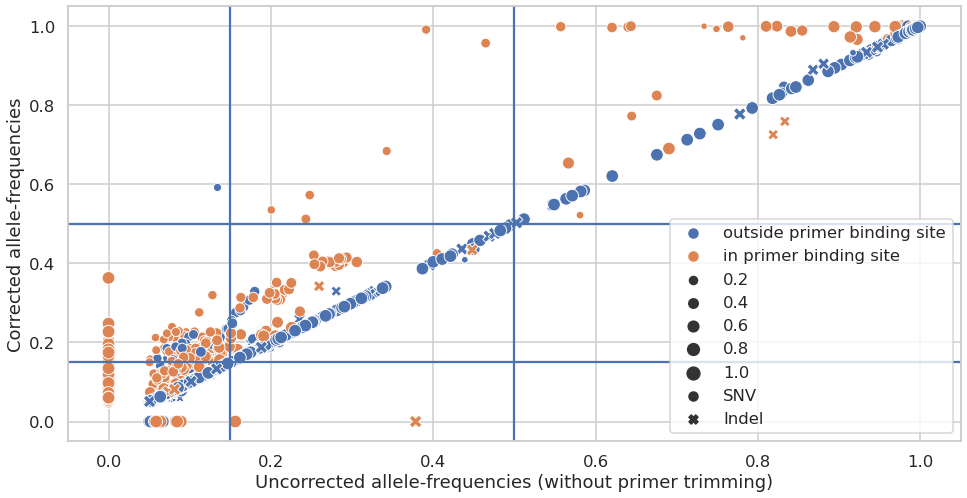

In [20]:
sns.set_theme(rc={"figure.figsize":(16, 8)}) # set figure width and height
sns.set_context('talk')
sns.set_style('whitegrid')
graph = sns.scatterplot(x=x_all, y=y_all, hue=hues, style=types, size=sizes)
graph.axhline(0.15)
graph.axvline(0.15)
graph.axhline(0.5)
graph.axvline(0.5)
plt.xlabel('Uncorrected allele-frequencies (without primer trimming)')
plt.ylabel('Corrected allele-frequencies')
plt.savefig('PBS_AF_figure.pdf')